# Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. 
Для этого мы применяем метод A/B–тестирования. 
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы 
оставалась базовая механика. 
В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, 
стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import stats
import scipy.stats as ss
import statsmodels.stats.api as sms
from scipy.stats import norm
import random
import pylab

%matplotlib inline

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
#     _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
#     for bar in bars:
#         if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
#             bar.set_facecolor('red')
#         else: 
#             bar.set_facecolor('grey')
#             bar.set_edgecolor('black')
    
#     plt.style.use('ggplot')
#     plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
#     plt.xlabel('boot_data')
#     plt.ylabel('frequency')
#     plt.title("Histogram of boot_data")
#     plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [3]:
# Файл о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
df_groups = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-nichiporenko/final_project/Проект_2_groups.csv", sep=';')
print(f'Размеры таблицы: {df_groups.shape[0]} строчки и {df_groups.shape[1]} столбца') # Cмотрим размеры 
df_groups.head()

Размеры таблицы: 74484 строчки и 2 столбца


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
# Здесь видим, что в целевая группа преобладает
df_groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [5]:
# id не повторятся, следовательно имеем 74484 пользователся в данной таблице
df_groups.id.nunique()

74484

In [6]:
# Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
df_users_visit = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-nichiporenko/final_project/Проект_2_active_studs.csv")
df_users_visit.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [7]:
# Сделаем из этих id список, чтобы в дальнейшем рассматривать только этих пользователей, потому что именно они учавствовали
# в тесте.
participating_id = df_users_visit.student_id.to_list()

In [8]:
# Файл с информацией об оплатах пользователей в дни проведения эксперимента
df_checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-nichiporenko/final_project/Проект_2_checks.csv', sep=';')
df_checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [9]:
df_checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [10]:
df_checks.student_id.count() == df_checks.student_id.nunique()

True

In [11]:
df_checks = df_checks.rename(columns={'student_id': 'id'})
df_checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [12]:
# Оставим только тех юзеров, которые заходили дни эксперимента.
# Остальных не следует рассматривать, так они не видели изменений.
df_participating = df_groups.query('id in @participating_id')
df_participating.head()

,id,grp
1,1627,A
10,2085,B
12,2215,B
43,3391,A
45,3401,B


In [13]:
# Дальше соединим df_participating с df_checks, чтобы увидеть сколько каждый пользователь принес денег
# Кто не совершал покупку в эти дни получает 0 в rev
df = df_participating.merge(df_checks, how='left', on='id')
df['rev'] = df.rev.fillna(0)
df.head()

,id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0


In [14]:
df_users_visit.nunique() == df_users_visit.count()

student_id    True
dtype: bool

In [15]:
# Описательная статистика для контрольной группы
# Большая часть значений равна нулю
df.query('grp == "A"').rev.describe()

count    1535.000000
mean       47.439739
std       290.766992
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: rev, dtype: float64

In [16]:
# Описательная статистика для экспериментальной группы
# В данной группе также большая часть значений равна нулю
df.query('grp == "B"').rev.describe()

count    6793.000000
mean       57.864567
std       313.197487
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

In [17]:
# Процентное содержание нулей в кажой группе
print('Процент нулевых значений в контрольной группе', round(df.query('grp == "A" and rev == 0').id.count() / df.query('grp == "A"').id.count() * 100, 2), '%')
print('Процент нулевых значений в экспериментальной группе', round(df.query('grp == "B" and rev == 0').id.count() / df.query('grp == "B"').id.count() * 100, 2), '%')

Процент нулевых значений в контрольной группе 94.92 %
Процент нулевых значений в экспериментальной группе 95.39 %


In [18]:
# Посмотрим размер групп, средние чеки и конверсию.
# Видно, что конверсия уменьшилась у экспериментальной группы, но средний чек вырос 11 пунктов.

# Функция, которая возвращает 1, если пользователь совершил покупку в эти, иначе вернет ноль.
def active_user(x):
    if x > 0:
        return True
    elif x == 0:
        return False
df['status_active'] = df.rev.apply(active_user)
df_con = df.groupby('grp', as_index=False)\
    .agg({'rev': 'mean', 'status_active': 'sum', 'id': 'count'})\
    .rename(columns={'rev': 'avg_revenue', 'status_active': 'count_active', 'id': 'count_users'})
df_con['conversion'] = df_con.count_active / df_con.count_users
df_con.head()
# Увидели подтверждение прошлого шага

,grp,avg_revenue,count_active,count_users,conversion
0,A,47.439739,78,1535,0.050814
1,B,57.864567,313,6793,0.046077


Видим, что имеются лишь небольшие различия в содеражнии нулевых значений в группах, поэтому будем рассматривать два возможных варианта: с нулевыми значениями в rev в группах; без нулевых значений в rev. Перед тем, как проводить A/B тесты: построим графики распределений групп, проверим группы на нормальность, посмотрим на различия в дисперсиях.

In [19]:
# Сделаем df, где будут представители только A группы с нулевыми значениями в rev
df_a = df.query('grp == "A"')
df_a.head()

,id,grp,rev,status_active
0,1627,A,990.0,True
3,3391,A,0.0,False
13,109623,A,0.0,False
15,133678,A,0.0,False
23,175944,A,0.0,False


In [20]:
# Сделаем df, где будут представители только A группы без нулевых значениями в rev
df_a_nozero = df.query('grp == "A" and rev > 0')
df_a_nozero.head()

,id,grp,rev,status_active
0,1627,A,990.0,True
319,287008,A,1830.0,True
448,332387,A,2910.0,True
508,347455,A,2820.0,True
718,445767,A,3660.0,True


In [21]:
# Сделаем df, где будут представители только B группы с нулевыми значениями в rev
df_b = df.query('grp == "B"')
df_b.head()

,id,grp,rev,status_active
1,2085,B,0.0,False
2,2215,B,0.0,False
4,3401,B,0.0,False
5,22994,B,0.0,False
6,26899,B,0.0,False


In [22]:
# Сделаем df, где будут представители только B группы без нулевых значений в rev
df_b_nozero = df.query('grp == "B" and rev > 0')
df_b_nozero.head()

,id,grp,rev,status_active
10,100300,B,990.0000,True
12,108270,B,290.0000,True
246,264473,B,1900.0001,True
279,274352,B,690.0000,True
299,280036,B,199.0000,True


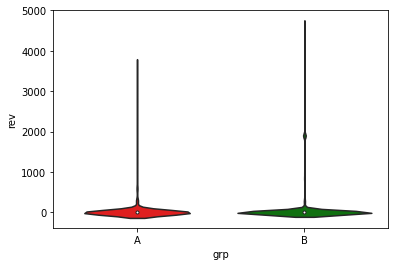

In [23]:
#скрипичный график
#Видно, что большая часть значений не более 200 распределились похожим образом.
sns.violinplot(x="grp", y="rev", data=df.query('rev>=0'), palette=["r", "g"])


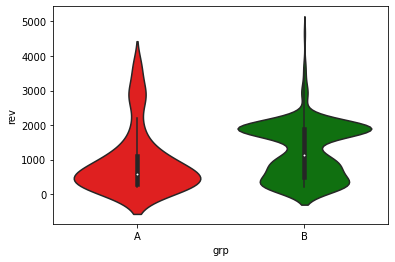

In [24]:
# Теперь посмотрим на значения, которые больше нуля.
# Пока довольно трудно сказать о статистических изменениях по графикам.
sns.violinplot(x="grp", y="rev", data=df.query('rev > 0'), palette=["r", "g"])

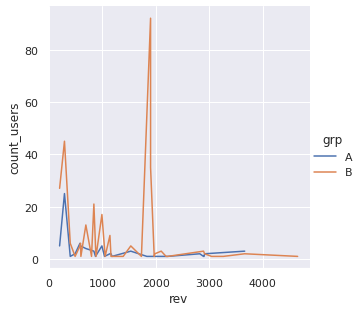

In [25]:
# Гистограммы распрделения для значений прибыли больше 0.
# Здесь видно, что различия среднего чека обеспечивает покупки на чуть менее 2000.
df_gist = df.query('rev > 0').groupby(['rev','grp'], as_index=False).id.count().rename(columns={'id': 'count_users'})
sns.set(rc={'figure.figsize':(11.7,3.27)})
sns.relplot(
    data=df_gist, kind="line",
    x="rev", y="count_users",
    hue="grp", height=4.27
)


Видно, что сильно выросли покупки чуть менее 2000 рублей и покуки около 1000 рублей. Это одни из главных причин увеличения среднего в группе B.



По графикам видно, что распредления у двух выборок довольно далеки от нормального, однако проверим данноу утверждения с помощью
тестов.

In [26]:
# У двух выборок p-value = 0, следовательно наши выборки (с нулевыми значениями) не имеют нормальное распредление
print(ss.normaltest(df_a.rev))
print(ss.normaltest(df_b.rev))

NormaltestResult(statistic=2235.0038926868115, pvalue=0.0)
NormaltestResult(statistic=7799.5839920248845, pvalue=0.0)


In [27]:
# У двух выборок p-value меньше 0.05, следовательно наши выборки (без нулевых значениями) не имеют нормальное распредление
print(ss.normaltest(df_a_nozero.rev))
print(ss.normaltest(df_b_nozero.rev))

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)
NormaltestResult(statistic=7.022269699078301, pvalue=0.029863005181946005)


In [28]:
# Проверяю различия в дисперсиях
# Pvalue < 0.05. Принимаю гипотезу о различии дисперсий у групп с нулевыми значениями
print('С нулевыми значениями. p-value =', ss.levene(df_a.rev, df_b.rev, center='mean')[1])
# Pvalue > 0.05. Не могу принять гипотезу о различии дисперсий у групп без нулевых значений
print('Без нулевых значений. p-value =', ss.levene(df_a_nozero.rev, df_b_nozero.rev, center='mean')[1])


С нулевыми значениями. p-value = 0.013129800854584504
Без нулевых значений. p-value = 0.5524868375224445


Выводы перед A/B тестированием.
Группы с нулевыми значениями в rev:
1. Обе выборки не нормального распределения;
2. Дисперсии отличаются;
3. Система сплитования нормальная;
4. Имеются явные выбросы;
5. В контрольной группе 94.92 % нулевых значений, в экспериментальной группе 95.39 %.


Группы без нулевых значений в rev:
1. Обе выборки не нормального распределения;
2. Дисперсии статистически не отличаются;
3. Система сплитования не очень из-за небольшого кол-ва данных;
4. Выбросы также имеются.

Выбор теста.
Для проведения теста имеем: t-test, U-критерий, bootstrap.
T-test не буду использовать из отсутствия нормального распределений, да и у групп с нулевыми значениями имеются различные дисперсии. U-критерий посмотрим, но вывод будем строить на основе bootstrap, так как результаты теста Манна Уитни сложно интерпретировать.

In [29]:
# Критерий Мана-Уитни для групп с нулевыми значениями в rev
# Статистически значимых различий U-критерий не показал.
ss.mannwhitneyu(df_a['rev'], df_b['rev'])

MannwhitneyuResult(statistic=5235110.0, pvalue=0.4908589066101978)

In [30]:
# Критерий Мана-Уитни для значений без нулей в rev.
# Статистически значимые различия U-критерий обнаружил.
ss.mannwhitneyu(df_a_nozero['rev'], df_b_nozero['rev'])

MannwhitneyuResult(statistic=8990.0, pvalue=0.000273244700505943)

In [31]:
# Bootstrap для групп с нулями в rev.
# Оставляем гипотезу о равных значения в двух группах, так как pvalue > 0.05.
booted_data = get_bootstrap(df_a['rev'], df_b['rev']) 
booted_data["p_value"]

0.34618164986816014

In [32]:
# Bootstrap для групп без нулей в rev.
# Принимаем гипотезу о различии в средних значения в двух группах, так как pvalue < 0.05.
booted_data = get_bootstrap(df_a_nozero['rev'], df_b_nozero['rev']) 
booted_data["p_value"]

0.01859658430369356

На этом этапе видно, что существуют два различных исхода тестирования: консервативное (в rev есть нулевые значения) и передовой (из rev убрали нулевые значения). Первый вариант можно принять, когда совем не хочется рисковать. Так на большую часть пользователей изменения вообще не повлияли, следует подробнее изучить второй вариант.  

In [33]:
# Возможно, во втором варианте изменения вызваны из-за разных размер выборок, 
# поэтому буду брать по 60 случайных знчений из двух групп. 
# После буду применять бутстрап для проверки на статистические различия. Сделаю 5 таких запусков, чтобы обезопасить себя 
# от фактора случайности.
# Также посчитаем средний pvalue для критерия Мана Уитни
sum_pvalues_boot = 0
n = 5
for i in range(n):
    df_int_a = df_a_nozero['rev'].sample(60, replace = False).values
    df_int_b = df_b_nozero['rev'].sample(60, replace = False).values
    booted_data = get_bootstrap(df_a_nozero['rev'], df_b_nozero['rev'])['p_value']
    sum_pvalues_boot += booted_data 
print(sum_pvalues_boot / n)

   



0.0182661230919667


In [34]:
sum_pvalues_u = 0
n = 1000
for i in range(n):
    df_int_a = df_a_nozero['rev'].sample(60, replace = False).values
    df_int_b = df_b_nozero['rev'].sample(60, replace = False).values
    sum_pvalues_u += ss.mannwhitneyu(df_int_a, df_int_b)[1]
print(sum_pvalues_u / n)

0.04408387574546974


Вывод.
Если мы совсем не хотим рисковать, то следует принять нулевую гипотезу, так как бутстрап и критерий Мана Уитни показали, что статистически в двух группах не наблюдаются (с нулевыми значениями в rev), однако альтернативная гипотеза имеет право на существоания (если убрать нулевые значения, которых большинство в двух группах). Чуть выше показал, что если размер выборок довести до одного размера, также статистические различия будут сохраняться в бутстрапе, но с тестом U уже не все так очевидно.
Я предлагаю принять гипотезу о различии в средних и запустить новую механику в данных момент, однако считаю, что необходимо дальнейшие исследования об услугах на которые повлияли изменения, также хотелось бы помотреть на корректность AA теста.

# Задание 3. Python

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Функция будет принимать два аргумента: файл с добавленными пользователями и исходные данные. Исходные данные - это таблица, которая была получена в первом задании, то есть пользователи без учета id в файлe group_add.
Функция add_information выводит исходный df и измененный df за счет добавления новых пользоватлей. Кроме этого, функция возвращает df, который следует использовать при построении графиков.

In [35]:
# Пример исходного df
df.head()

,id,grp,rev,status_active
0,1627,A,990.0,True
1,2085,B,0.0,False
2,2215,B,0.0,False
3,3391,A,0.0,False
4,3401,B,0.0,False


In [36]:
# Функция для обновления данных
# path - путь к файлу, df_original - исходный df
def add_information(path, df_original):
    df_add = pd.read_csv(path) #Загружаем таблицу с дополнительными пользователями
    df_add1 = df_add.merge(df_checks, how='left') #Добавляем доп пользователям их затраты из таблицы checks.csv
    df_add1['rev'] = df.rev.fillna(0) # Ставим 0 в rev, если пользователь не совершал покупки
    df_add1['status_active'] = df_add1['rev'].apply(lambda rev: 1 if rev>0 else 0) #Совершал ли покупку пользователь
    df_2 = df_original.copy() #Делаем копию основного df, чтобы не менять df_original
    df_2 = df_2.merge(df_add1, how='outer') # Добавляем к основному df новых пользователей
#     Дальше идет расчет метрик для исходного df
    df_original = df_original.groupby('grp', as_index=False)\
            .agg({'rev': 'mean', 'status_active': 'sum', 'id': 'count'})\
            .rename(columns={'rev': 'avg_revenue', 'status_active': 'count_active', 'id': 'count_users'})
    df_original['conversion'] = df_original.count_active / df_original.count_users
#     Теперь метрики для измененного df
    df_2 = df_2.groupby('grp', as_index=False)\
        .agg({'rev': 'mean', 'status_active': 'sum', 'id': 'count'})\
        .rename(columns={'rev': 'avg_revenue', 'status_active': 'count_active', 'id': 'count_users'})
    df_2['conversion'] = df_2.count_active / df_2.count_users
    print('\t\t  Исходные метрики')
    print(df_original)
    print()
    print('\t     Метрики поле обновления данных')
    print(df_2)
    return df_2

In [38]:
# Функция для визуализации обновленных метрик.
def visualization(df_for_visualization):
    plt.figure(figsize=(10,6)) #Размер графиков
    plt.subplots_adjust(wspace=0.3, hspace=0.6) #Размер между графиками
    pylab.subplot (2, 2, 1) #Первая позиция в сетке 2 на 2
    sns.barplot(data=df_for_visualization, x='grp', y='avg_revenue') # График для средней прибыли по группам
    pylab.title ("Средние чеки") #Заголовок первого графика
#     Дальше следуют аналогичные действия, поэтому описывать не буду
    pylab.subplot (2, 2, 2)
    sns.barplot(data=df_for_visualization, x='grp', y='count_active')
    pylab.title ("Кол-во активных пользоватлей")
    pylab.subplot (2, 2, 3)
    sns.barplot(data=df_for_visualization, x='grp', y='count_users')
    pylab.title ("Кол-во пользователей")
    pylab.subplot (2, 2, 4)
    pylab.title ("Конверсия")
    sns.barplot(data=df_for_visualization, x='grp', y='conversion')


/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-nichiporenko/final_project/Проект_2_group_add.csv - путь к файлу в моем юпитере

In [41]:
path_to_file = input('Введите путь к файлу ') 
df_for_visualization = add_information(path_to_file, df) #Вызываем функцию, чтобы вывести результаты, а также вернуть значения 
# для функции графиков и положить его в переменную path_to_file

Введите путь к файлу /mnt/HC_Volume_18315164/home-jupyter/jupyter-d-nichiporenko/final_project/Проект_2_group_add.csv
		  Исходные метрики
  grp  avg_revenue  count_active  count_users  conversion
0   A    47.439739            78         1535    0.050814
1   B    57.864567           313         6793    0.046077

	     Метрики поле обновления данных
  grp  avg_revenue  count_active  count_users  conversion
0   A    46.769428            78         1557    0.050096
1   B    57.605129           316         6863    0.046044


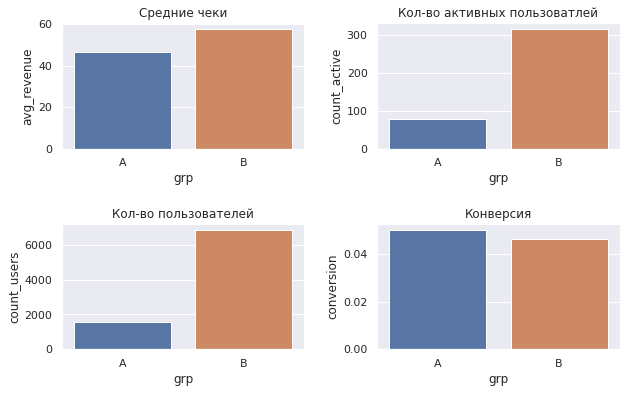

In [42]:
visualization(df_for_visualization)

# Задание 2. SQL.

In [43]:
# Импорт библиотеки для работы с clickhouse
import pandahouse as ph

In [44]:
# Парамаетры подключения к clickhouse
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Условие 1 задачи.
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [45]:
# Решение 1 задачи
q_1 = '''
    SELECT
        uniqExact(st_id) AS count_good_fellows
    FROM
        (
            SELECT
                st_id,
                SUM(correct) AS count_correct_tasks
            FROM peas
            WHERE correct = 1
            GROUP BY
                st_id
            HAVING
                count_correct_tasks >= 20
        )
    '''

In [46]:
df_sql_1 = ph.read_clickhouse(query=q_1, connection=connection_default)
print(f'Кол-во усердных учеников равно {df_sql_1.count_good_fellows[0]}')

Кол-во усердных учеников равно 136


Условие 2 задачи.
Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
ARPU (Доход / Общее кол-во пользователей)
ARPAU (Доход / Кол-во активных пользоватлей)
CR в покупку (Пользователи, которые купили курс / Общее кол-во пользоватлей) 
СR активного пользователя в покупку (Пользователи, которые купили курс/ Общее кол-во пользвателей)
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике (Пользователи, которые активные в математике и купили курс / Кол-во пользователей, которые купили кур по математике).

ARPU считается относительно всех пользователей, попавших в группы.
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

Активными считаю тех, кто решил >10 задач или активен по математике.

In [47]:
# Решение 2 задачи 
q = '''
SELECT 
    test_grp,
    SUM(money) / uniqExact(st_id) AS ARPU,
    SUM(money) / countIf(DISTINCT st_id, correct > 10 OR active_math = 1) AS ARPAU,
    SUM(purchase) / count(st_id) AS CR,
    SUM(purchase) / countIf(st_id, correct > 10 OR active_math = 1) AS CRA,
    sumIf(purchase, buy_math = 1 AND active_math = 1) / countIf(st_id, buy_math = 1) AS CR_math
FROM    
    (SELECT st_id, test_grp, subjects, correct, active_math, If(correct > 10, 1,0) AS active_user, money, If(money > 0, 1, 0) AS purchase, If(money > 0 AND subject = 'Math', 1, 0) AS buy_math
    FROM
        (SELECT *
        FROM    
            studs AS l
        LEFT JOIN
            (SELECT st_id, groupArray(subject) AS subjects, SUM(correct) AS correct, SUM(active_math) AS active_math
            FROM
                (SELECT
                    st_id,
                    subject,
                    SUM(correct) AS correct,
                    If(correct > 2 AND subject='Math', 1, 0) AS active_math
                FROM peas
                GROUP BY 
                    st_id,
                    subject)
            GROUP BY
                st_id) AS r
        ON l.st_id = r.st_id) AS l
    LEFT JOIN 
        final_project_check AS r
    ON l.st_id = r.st_id)
GROUP BY
    test_grp
    '''

In [48]:
df_sql = ph.read_clickhouse(query=q, connection=connection_default)
print(df_sql)

  test_grp          ARPU         ARPAU        CR       CRA  CR_math
0  control   4540.983607  10335.820896  0.058442  0.131387    0.375
1    pilot  11508.474576  31146.788991  0.140523  0.361345    0.250
